<a href="https://colab.research.google.com/github/hxngxS/23WEB1/blob/main/Garbage_Classification_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Garbage Classification

### 라이브러리 불러오기

- 수업에서 다룬 tensorflow.keras 모듈들을 불러옵니다.

- 사전 지식이 있는 학생이라면 기타 프레임워크(Pytorch)도 사용 가능합니다.


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet, DenseNet121, EfficientNetB0, Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from PIL import Image
import pandas as pd

### 데이터 다운로드

- 아래의 코드로 데이터를 다운받습니다.


In [10]:
#!pip install gdown

In [5]:
import zipfile
import gdown

file_id = '1gLKQe5Qxe8fC19r7QAfXmBtg_1zLDen6'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'dataset.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1gLKQe5Qxe8fC19r7QAfXmBtg_1zLDen6
From (redirected): https://drive.google.com/uc?id=1gLKQe5Qxe8fC19r7QAfXmBtg_1zLDen6&confirm=t&uuid=d8cd77f0-5e75-4300-8c53-91df34165eb2
To: /content/dataset.zip
100%|██████████| 52.5M/52.5M [00:00<00:00, 103MB/s]


'dataset.zip'

In [6]:
# 압축 해제
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [19]:
def load_images_from_folder(folder, target_size=(299, 299)):
    images = []
    labels = []
    classes = sorted(os.listdir(folder))  # 각 클래스 폴더명
    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                image = load_img(image_path, target_size=target_size)  # 이미지 로드 및 리사이즈
                images.append(image)
                labels.append(class_idx)  # 클래스 인덱스를 라벨로 사용
    return np.array(images), np.array(labels)

x_train, y_train = load_images_from_folder('/content/dataset/train')
x_test, y_test = load_images_from_folder('/content/dataset/test')

### EDA 및 데이터 특성 파악 및 시각화

- 다양한 방법을 사용해 데이터의 기본 정보, 특성, 분포 등을 파악하고 시각화해보세요.

In [20]:
# 데이터셋 구조 출력
print("Training data shape: ", x_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)

# 클래스 이름
class_names = ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic']

print("\nClass names:")
for idx, name in enumerate(class_names):
    print(f"{idx}: {name}")

Training data shape:  (3720, 299, 299, 3)
Training labels shape:  (3720,)
Test data shape:  (930, 299, 299, 3)
Test labels shape:  (930,)

Class names:
0: battery
1: glass
2: metal
3: organic
4: paper
5: plastic


In [21]:
# 클래스 이름
class_names = ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic']

#y_train = np.argmax(y_train, axis=1)
#y_test = np.argmax(y_test, axis=1)

# 훈련 데이터 개요
train_class_counts = {class_name: 0 for class_name in class_names}
for label in y_train:
    #class_name = class_names[int(label)]  # 라벨을 정수형으로 변환하여 클래스 이름을 선택
    class_name = class_names[label]
    train_class_counts[class_name] += 1

# 테스트 데이터 개요
test_class_counts = {class_name: 0 for class_name in class_names}
for label in y_test:
    #class_name = class_names[int(label)]  # 라벨을 정수형으로 변환하여 클래스 이름을 선택
    class_name = class_names[label]
    test_class_counts[class_name] += 1

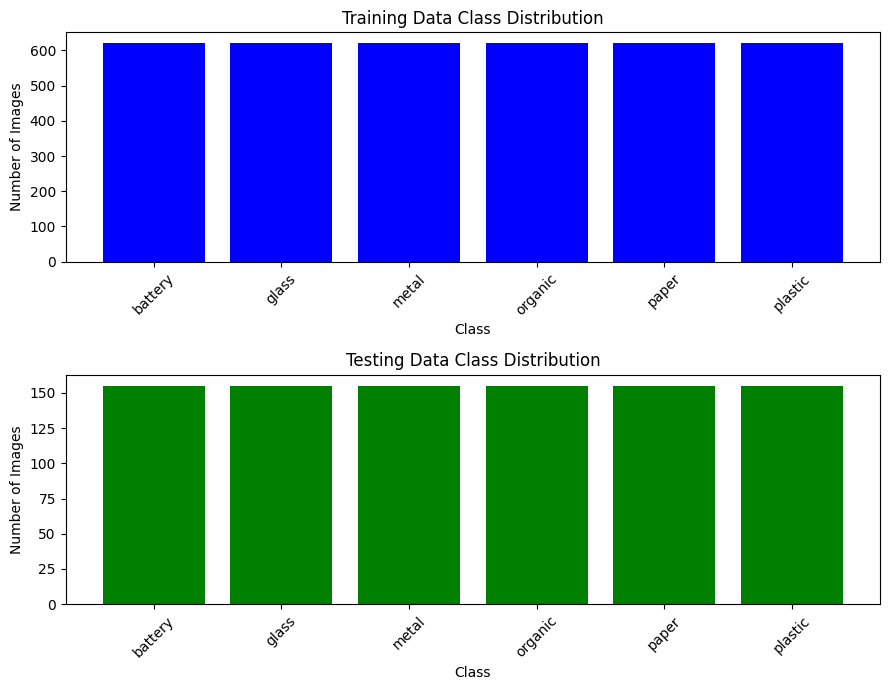

In [22]:
# 각 클래스당 분포를 그래프로 그리기
fig, ax = plt.subplots(2, 1, figsize=(9, 7))

# 훈련 데이터 분포
ax[0].bar(train_class_counts.keys(), train_class_counts.values(), color='blue')
ax[0].set_title('Training Data Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=45)

# 테스트 데이터 분포
ax[1].bar(test_class_counts.keys(), test_class_counts.values(), color='green')
ax[1].set_title('Testing Data Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Training images:


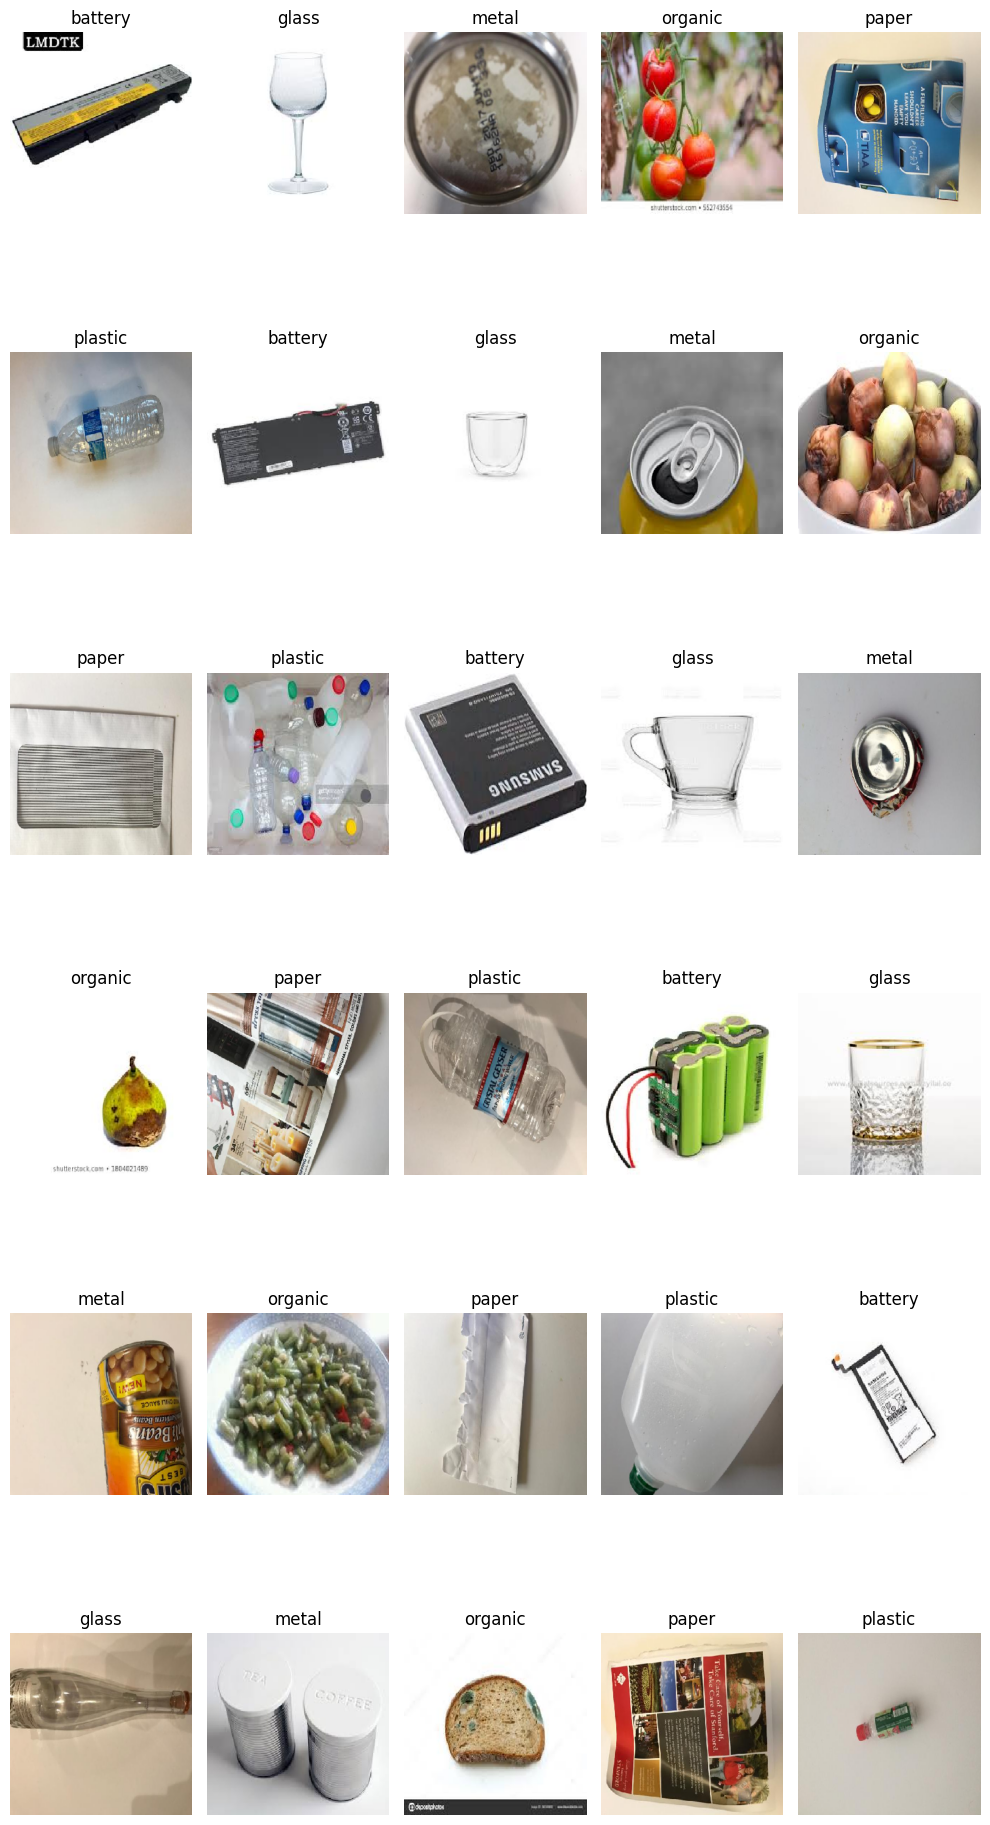

Testing images:


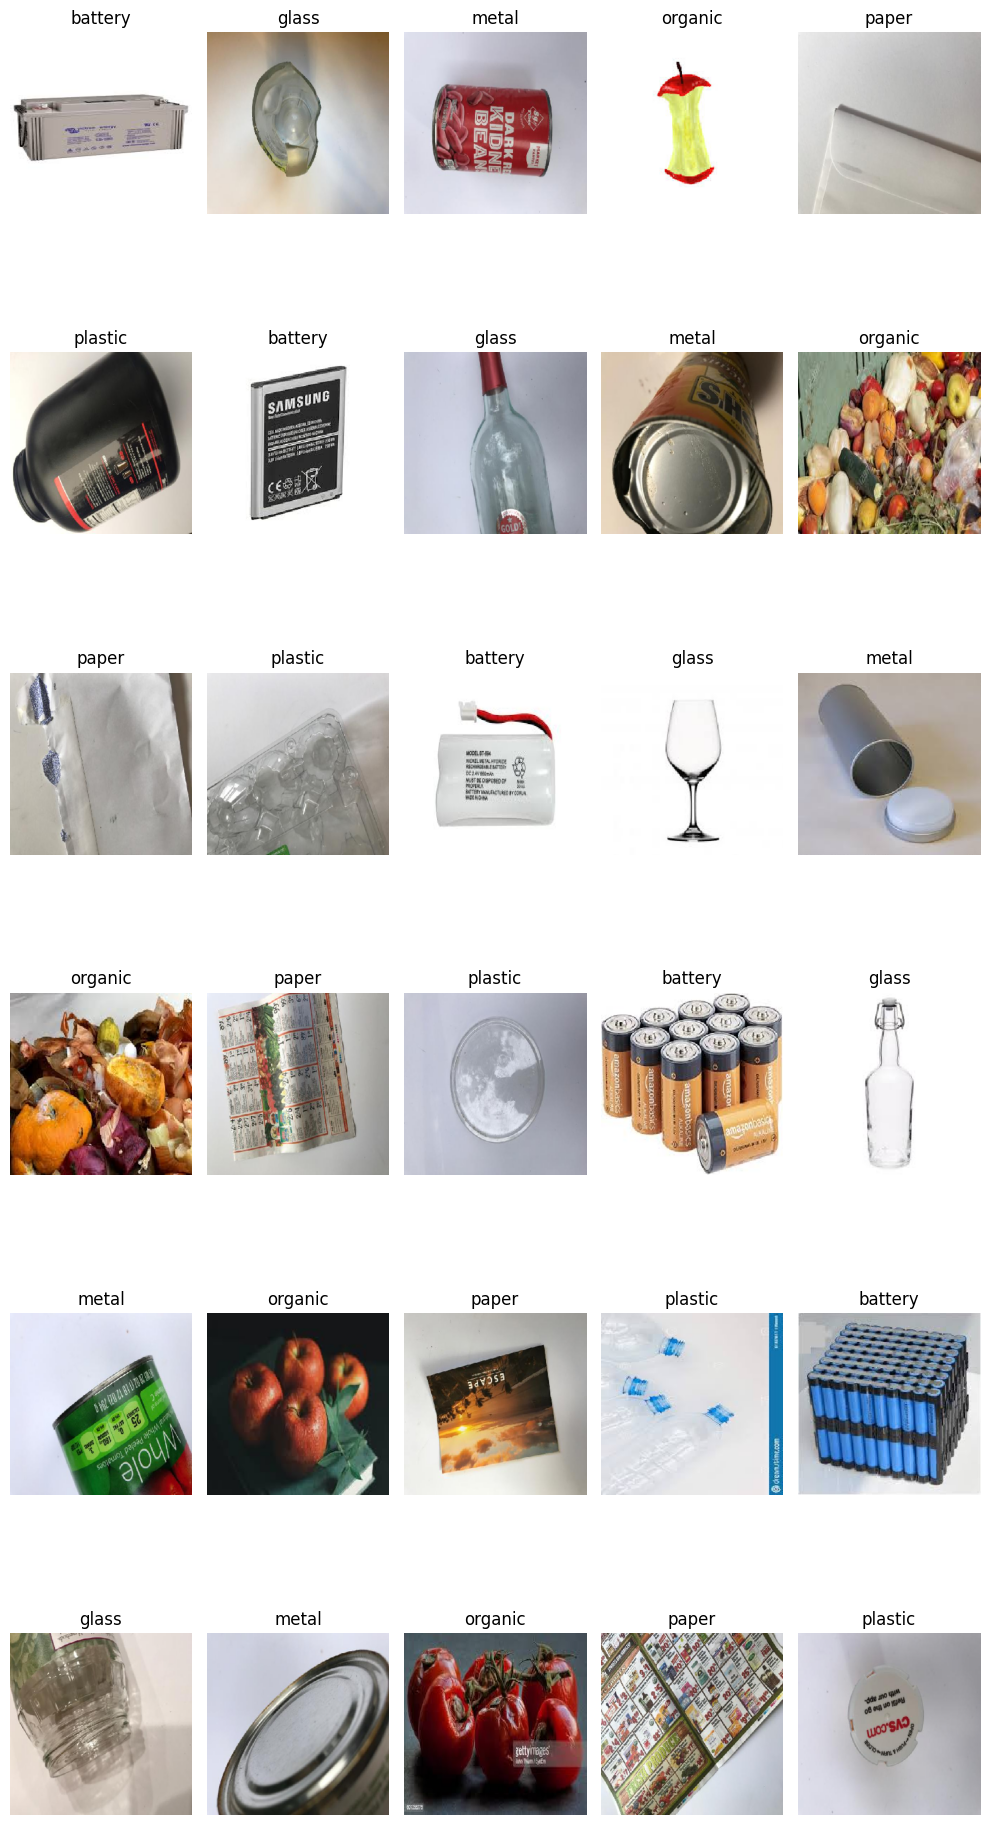

In [23]:
# 이미지 시각화 함수
def visualize_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(10, 20))
    for i in range(num_images):
        for j in range(len(class_names)):  # 각 클래스에 대해
            class_indices = [index for index in range(len(labels)) if labels[index] == j]

            if len(class_indices) == 0:
                continue  # 만약 해당 클래스에 이미지가 없다면 건너뛰기

            selected_index = class_indices[i % len(class_indices)]
            img = images[selected_index]
            plt.subplot(len(class_names), num_images, i * len(class_names) + j + 1)
            plt.imshow(img)
            plt.title(class_names[j])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# 훈련 이미지 시각화
print("Training images:")
visualize_images(x_train, y_train, class_names)

# 테스트 이미지 시각화
print("Testing images:")
visualize_images(x_test, y_test, class_names)

### 이미지 전처리 및 데이터 증강

- 이미지 정규화, 리사이징, 데이터 증강, mixup 등 다양한 방법을 사용해서 학습데이터를 생성합니다.
- 정규화와 리사이징만 적용하여 검증 데이터와 test 데이터를 생성합니다.

In [24]:
# 훈련 및 검증 데이터 분할
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 라벨을 one-hot 인코딩으로 변환
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 크기 및 배치 사이즈 설정
IMG_HEIGHT = 299
IMG_WIDTH = 299
BATCH_SIZE = 16

# 데이터 증강 및 정규화
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 모든 이미지 픽셀 값을 0-1 범위로 정규화

    ##증강을 다양하게 적용해봐라
    rotation_range = 45,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.1,
    horizontal_flip = True
)


# 검증 데이터 정규화
val_datagen = ImageDataGenerator(
    rescale=1./255,
    ##증강을 다양하게 적용해봐라
    rotation_range = 45,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.1,
    horizontal_flip = True
    )

# 테스트 데이터 정규화
test_datagen = ImageDataGenerator(
    rescale=1./255,
    ##증강을 다양하게 적용해봐라
    rotation_range = 45,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.1,
    horizontal_flip = True
    )

# 훈련 데이터 생성
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=16,
    shuffle=True
)

# 검증 데이터 생성
val_generator = val_datagen.flow(
    x_val, y_val,
    batch_size=16,
    shuffle=False
)

# 테스트 데이터 생성
test_generator = test_datagen.flow(
    x_test, y_test,
    batch_size=16,
    shuffle=False
)

In [26]:
# 각 데이터셋의 크기 출력
print(f"Number of training batches: {len(train_generator)}")
print(f"Number of validation batches: {len(val_generator)}")
print(f"Number of testing batches: {len(test_generator)}")

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Testing data shape: {x_test.shape}")

print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Testing labels shape: {y_test.shape}")

Number of training batches: 186
Number of validation batches: 47
Number of testing batches: 59
Training data shape: (2976, 299, 299, 3)
Validation data shape: (744, 299, 299, 3)
Testing data shape: (930, 299, 299, 3)
Training labels shape: (2976, 10)
Validation labels shape: (744, 10)
Testing labels shape: (930, 10)


### 모델 생성 및 학습

- 다양한 전이학습 CNN 모델들을 실험하고, 성능을 비교해 봅니다.
- 적절한 모델, 옵티마이저, 하이퍼파라미터 등을 설정합니다.

In [27]:
from tensorflow.keras.applications import InceptionV3, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
model = Sequential([
    base_model,  # 선택한 사전 학습된 모델을 기본 모델로 추가
    GlobalAveragePooling2D(),  # 특성 맵을 1차원으로 변환
    Dense(512, activation='relu'),  # 512 유닛의 Dense 레이어와 ReLU 활성화 함수
    Dropout(0.5),  # 50% 드롭아웃
    Dense(10, activation='softmax')  # 6개의 클래스에 대한 소프트맥스 활성화 함수를 갖는 출력 레이어
])

In [ ]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001,
                             beta_1=0.9,
                             beta_2=0.999),  # Adam 옵티마이저와 학습률 설정 ##Adam 찾아서 하나씩 적용해봐라
              loss='categorical_crossentropy',  # 손실 함수 설정
              metrics=['accuracy'])  # 평가 지표로 정확도(accuracy) 설정

# 모델 학습
EPOCHS = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 19/186 ━━━━━━━━━━━━━━━━━━━━ 46:07 17s/step - accuracy: 0.2913 - loss: 1.9276

### 학습 결과 시각화

- 학습 과정을 저장하여 시각화함으로써 학습 추이 및 오버피팅 여부를 파악합니다.

In [ ]:
# 학습 결과 시각화
acc = history.history['accuracy']  # 훈련 정확도 기록
val_acc = history.history['val_accuracy']  # 검증 정확도 기록
loss = history.history['loss']  # 훈련 손실 기록
val_loss = history.history['val_loss']  # 검증 손실 기록

epochs_range = range(EPOCHS)  # epoch 범위 설정

plt.figure(figsize=(30, 10))  # 전체 플롯의 크기 설정
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 서브플롯 설정
plt.plot(epochs_range, acc, label='Training Accuracy')  # 훈련 정확도 그래프 플롯
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # 검증 정확도 그래프 플롯
plt.legend(loc='lower right')  # 범례 위치 설정
plt.title('Training and Validation Accuracy')  # 그래프 제목 설정

plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 서브플롯 설정
plt.plot(epochs_range, loss, label='Training Loss')  # 훈련 손실 그래프 플롯
plt.plot(epochs_range, val_loss, label='Validation Loss')  # 검증 손실 그래프 플롯
plt.legend(loc='upper right')  # 범례 위치 설정
plt.title('Training and Validation Loss')  # 그래프 제목 설정

plt.show()

### 모델 평가

- 적절한 평가지표를 선택해 모델의 성능을 평가합니다.
- test 데이터셋을 사용해 최종적인 성능을 확인합니다.
- 목표 Accuracy: 93% 이상

### 보너스 과제! 나만의 CNN 모델 구축
- Transfer learning이 아닌 나만의 CNN 구조 만들어 보기
- 기존의 Baseline CNN 구조를 참고해서 직접 레이어들을 쌓아보세요.
- Trnsfer learning 모델의 성능과 비교해 보세요.